In [1]:
!pip install torch==2.4.1 transformers==4.44.2 datasets==3.0.1 nltk==3.9.1 pandas==2.2.3 matplotlib==3.8.4 evaluate==0.4.5 rouge_score>=0.1.2 sentence-transformers==2.7.0 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.4.1 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.4.1 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.6.1 which is incompatible.


In [2]:
# Uninstall conflicting packages
!pip uninstall -y torch torchvision torchaudio pandas fsspec gcsfs -q
# Install compatible versions
!pip install torch torchvision torchaudio pandas transformers datasets nltk matplotlib evaluate rouge_score sentence-transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15

In [3]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json -O train-v1.1.json

--2025-07-13 18:15:03--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘train-v1.1.json’

train-v1.1.json     100%[===================>]  28.88M  --.-KB/s    in 0.08s   

2025-07-13 18:15:06 (345 MB/s) - ‘train-v1.1.json’ saved [30288272/30288272]



In [4]:
import json

with open('train-v1.1.json', 'r', encoding='utf-8') as f:
    squad_data = json.load(f)

# Print the first paragraph to inspect
print("Sample data:", squad_data['data'][0]['paragraphs'][0])

Sample data: {'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'qas': [{'answers': [{'answer_start': 515, 'text': 'Saint Bernadette Soubirous'}], 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'id': '5733be284776f41900661182'}, {'answers': [{'answer_start': 188, 'text': 'a copper statue of Christ'

In [5]:
import pandas as pd
from datasets import Dataset, Features, Value

data = []
for article in squad_data['data']:
    for paragraph in article['paragraphs']:
        context = paragraph['context'].strip()
        for qa in paragraph['qas']:
            question = qa['question'].strip()
            answer = qa['answers'][0]['text'].strip() if qa['answers'] else ""
            if context and question and answer:  # Basic cleaning
                data.append({"context": context, "question": question, "answer": answer})

# Limit to 100 samples for quick testing
data = data[:100]

# Create DataFrame and Dataset
df = pd.DataFrame(data)
features = Features({
    "context": Value("string"),
    "question": Value("string"),
    "answer": Value("string")
})
dataset = Dataset.from_pandas(df, features=features)
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

print(f"Train size: {len(train_dataset)} | Eval size: {len(eval_dataset)}")
print("First train example:", train_dataset[0])

Train size: 80 | Eval size: 20
First train example: {'context': "In 1919 Father James Burns became president of Notre Dame, and in three years he produced an academic revolution that brought the school up to national standards by adopting the elective system and moving away from the university's traditional scholastic and classical emphasis. By contrast, the Jesuit colleges, bastions of academic conservatism, were reluctant to move to a system of electives. Their graduates were shut out of Harvard Law School for that reason. Notre Dame continued to grow over the years, adding more colleges, programs, and sports teams. By 1921, with the addition of the College of Commerce, Notre Dame had grown from a small college to a university with five colleges and a professional law school. The university continued to expand and add new residence halls and buildings with each subsequent president.", 'question': 'Which college did Notre Dame add in 1921?', 'answer': 'College of Commerce'}


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires gcsfs!=2025.5.0,>=2023.3.0, which is not installed.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.1 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Torch version: 2.7.1+cu126
GPU available: True
--2025-07-13 18:30:27--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘train-v1.1.json’

train-v1.1.json     100%[===================>]  28.88M  --.-KB/s    in 0.07s   

2025-07-13 18:30:27 (443 MB/s) - ‘train-v1.1.json’ saved [30288272/30288272]

Sample data: {'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind th

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Fine-tuning started...


Epoch,Training Loss,Validation Loss,Rouge1,Rougel
1,6.277500,5.750767,0.328613,0.298354
2,3.733100,3.037811,0.360249,0.324975
3,3.088000,2.223382,0.408879,0.372439


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Running final evaluation...


Final Evaluation Results:
  eval_loss: 2.223381519317627
  eval_rouge1: 0.4088792920468986
  eval_rougeL: 0.3724393817985359
  eval_runtime: 1.9014
  eval_samples_per_second: 10.519
  eval_steps_per_second: 5.259
  epoch: 3.0
Context: The Lobund Institute grew out of pioneering research in germ-free-life which began in 1928. This are...
Answer: The Lobund Institute
Generated Question: Lobund was the first research organization to answer whether animal life was possible without bacteria?
Reference Question: Work on a germ-free-life ended up in the creation of which Notre Dame institute?


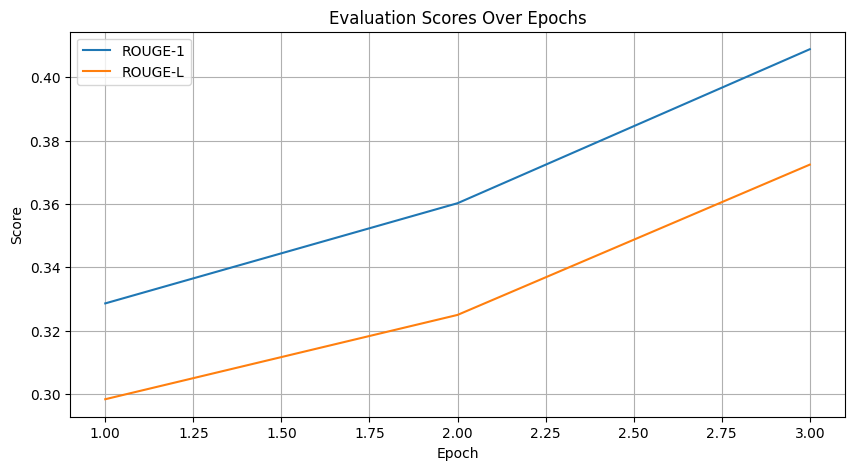

Model and tokenizer saved!


In [12]:
# Install dependencies
!pip uninstall -y torch torchvision torchaudio pandas fsspec gcsfs -q
!pip install torch torchvision torchaudio pandas transformers datasets nltk matplotlib evaluate rouge_score sentence-transformers -q
# Restart runtime after installation

import json
import pandas as pd
from datasets import Dataset, Features, Value
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
import evaluate
import matplotlib.pyplot as plt
import torch
import nltk
import numpy as np  # Added missing import
nltk.download('punkt')

# Verify setup
print(f"Torch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")

# Step 2: Download and load dataset
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json -O train-v1.1.json
with open('train-v1.1.json', 'r', encoding='utf-8') as f:
    squad_data = json.load(f)
print("Sample data:", squad_data['data'][0]['paragraphs'][0])

# Step 3: Clean and prepare dataset
data = []
for article in squad_data['data']:
    for paragraph in article['paragraphs']:
        context = paragraph['context'].strip()
        for qa in paragraph['qas']:
            question = qa['question'].strip()
            answer = qa['answers'][0]['text'].strip() if qa['answers'] else ""
            if context and question and answer:
                data.append({"context": context, "question": question, "answer": answer})

data = data[:100]
df = pd.DataFrame(data)
features = Features({
    "context": Value("string"),
    "question": Value("string"),
    "answer": Value("string")
})
dataset = Dataset.from_pandas(df, features=features)
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]
print(f"Train size: {len(train_dataset)} | Eval size: {len(eval_dataset)}")
print("First train example:", train_dataset[0])

# Step 4: Fine-tune the model
model_name = "valhalla/t5-small-qg-hl"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

def preprocess(examples):
    inputs = [f"generate question: {ctx} {ans}" for ctx, ans in zip(examples['context'], examples['answer'])]
    targets = examples['question']
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length", return_tensors=None)
    labels = tokenizer(targets, max_length=32, truncation=True, padding="max_length")["input_ids"]
    model_inputs["labels"] = labels
    return model_inputs

tokenized_train_dataset = train_dataset.map(preprocess, remove_columns=train_dataset.column_names, batched=True)
tokenized_eval_dataset = eval_dataset.map(preprocess, remove_columns=eval_dataset.column_names, batched=True)

tokenized_train_dataset = tokenized_train_dataset.with_format("torch")
tokenized_eval_dataset = tokenized_eval_dataset.with_format("torch")

training_args = TrainingArguments(
    output_dir="./qg-finetuned",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,  # Increased to 3
    eval_strategy="epoch",
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    save_total_limit=1,
    fp16=True,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions[0] if isinstance(predictions, tuple) else predictions
    predictions = np.argmax(predictions, axis=-1) if predictions.ndim == 3 else predictions
    labels = np.argmax(labels, axis=-1) if labels.ndim == 3 else labels

    def decode_sequences(sequences):
        return [tokenizer.decode(seq, skip_special_tokens=True) for seq in sequences]

    decoded_preds = decode_sequences(predictions)
    decoded_labels = decode_sequences(labels)

    rouge = evaluate.load("rouge")
    rouge_score = rouge.compute(predictions=decoded_preds, references=decoded_labels)

    return {
        "rouge1": rouge_score["rouge1"],
        "rougeL": rouge_score["rougeL"]
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    compute_metrics=compute_metrics
)

print("Fine-tuning started...")
trainer.train()
print("Running final evaluation...")
results = trainer.evaluate()
print("Final Evaluation Results:")
for metric, score in results.items():
    print(f"  {metric}: {score}")

# Step 5: Generate and evaluate sample questions
from transformers import GenerationConfig
model.eval()
sample = eval_dataset[0]
inputs = tokenizer(f"generate question: {sample['context']} {sample['answer']}", max_length=256, truncation=True, padding="max_length", return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

generation_config = GenerationConfig(early_stopping=True, num_beams=5, max_length=128)  # Adjusted
outputs = model.generate(**inputs, generation_config=generation_config)
generated_question = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Context: {sample['context'][:100]}...")
print(f"Answer: {sample['answer']}")
print(f"Generated Question: {generated_question}")
print(f"Reference Question: {sample['question']}")

# Step 6: Plot evaluation scores
log_history = trainer.state.log_history
epochs = [entry['epoch'] for entry in log_history if 'eval_rouge1' in entry]
rouge1_scores = [entry['eval_rouge1'] for entry in log_history if 'eval_rouge1' in entry]
rougeL_scores = [entry['eval_rougeL'] for entry in log_history if 'eval_rougeL' in entry]

plt.figure(figsize=(10, 5))
plt.plot(epochs, rouge1_scores, label='ROUGE-1')
plt.plot(epochs, rougeL_scores, label='ROUGE-L')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Scores Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Step 7: Save the model
model.save_pretrained("./qg-finetuned/final")
tokenizer.save_pretrained("./qg-finetuned/final")
print("Model and tokenizer saved!")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires gcsfs!=2025.5.0,>=2023.3.0, which is not installed.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.1 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Torch version: 2.7.1+cu126
GPU available: True
--2025-07-13 18:40:38--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘train-v1.1.json’

train-v1.1.json     100%[===================>]  28.88M  --.-KB/s    in 0.08s   

2025-07-13 18:40:39 (360 MB/s) - ‘train-v1.1.json’ saved [30288272/30288272]

Sample data: {'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind th

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/640 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Fine-tuning started...


Epoch,Training Loss,Validation Loss,Rouge1,Rougel
1,1.359900,1.123563,0.468239,0.447952
2,1.185400,1.051612,0.474566,0.454544


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Running final evaluation...


Final Evaluation Results:
  eval_loss: 1.0516119003295898
  eval_rouge1: 0.47456620661431465
  eval_rougeL: 0.45454379559304303
  eval_runtime: 4.061
  eval_samples_per_second: 39.399
  eval_steps_per_second: 9.85
  epoch: 2.0
Context: In 1919 Father James Burns became president of Notre Dame, and in three years he produced an academi...
Answer: three years
Generated Question: What was the name of the president of Notre Dame in 1919?
Reference Question: Over how many years did the change to national standards undertaken at Notre Dame in the early 20th century take place?


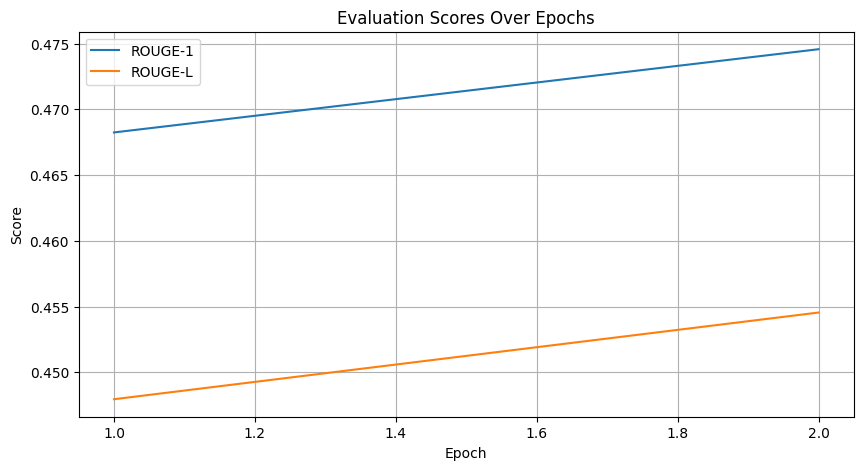

Model and tokenizer saved!


In [20]:
# Install dependencies
!pip uninstall -y torch torchvision torchaudio pandas fsspec gcsfs -q
!pip install torch torchvision torchaudio pandas transformers datasets nltk matplotlib evaluate rouge_score sentence-transformers -q
# Restart runtime after installation

import json
import pandas as pd
from datasets import Dataset, Features, Value
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
import evaluate
import matplotlib.pyplot as plt
import torch
import nltk
import numpy as np  # Added missing import
nltk.download('punkt')

# Verify setup
print(f"Torch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")

# Step 2: Download and load dataset
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json -O train-v1.1.json
with open('train-v1.1.json', 'r', encoding='utf-8') as f:
    squad_data = json.load(f)
print("Sample data:", squad_data['data'][0]['paragraphs'][0])

# Step 3: Clean and prepare dataset
data = []
for article in squad_data['data']:
    for paragraph in article['paragraphs']:
        context = paragraph['context'].strip()
        for qa in paragraph['qas']:
            question = qa['question'].strip()
            answer = qa['answers'][0]['text'].strip() if qa['answers'] else ""
            if context and question and answer:
                data.append({"context": context, "question": question, "answer": answer})

data = data[:800]
df = pd.DataFrame(data)
features = Features({
    "context": Value("string"),
    "question": Value("string"),
    "answer": Value("string")
})
dataset = Dataset.from_pandas(df, features=features)
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]
print(f"Train size: {len(train_dataset)} | Eval size: {len(eval_dataset)}")
print("First train example:", train_dataset[0])

# Step 4: Fine-tune the model
model_name = "valhalla/t5-small-qg-hl"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

def preprocess(examples):
    inputs = [f"generate question: {ctx} {ans}" for ctx, ans in zip(examples['context'], examples['answer'])]
    targets = examples['question']
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length", return_tensors=None)
    labels = tokenizer(targets, max_length=32, truncation=True, padding="max_length")["input_ids"]
    model_inputs["labels"] = labels
    return model_inputs

tokenized_train_dataset = train_dataset.map(preprocess, remove_columns=train_dataset.column_names, batched=True)
tokenized_eval_dataset = eval_dataset.map(preprocess, remove_columns=eval_dataset.column_names, batched=True)

tokenized_train_dataset = tokenized_train_dataset.with_format("torch")
tokenized_eval_dataset = tokenized_eval_dataset.with_format("torch")

training_args = TrainingArguments(
    output_dir="./qg-finetuned",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    eval_strategy="epoch",
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    save_total_limit=1,
    fp16=True,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions[0] if isinstance(predictions, tuple) else predictions
    predictions = np.argmax(predictions, axis=-1) if predictions.ndim == 3 else predictions
    labels = np.argmax(labels, axis=-1) if labels.ndim == 3 else labels

    def decode_sequences(sequences):
        return [tokenizer.decode(seq, skip_special_tokens=True) for seq in sequences]

    decoded_preds = decode_sequences(predictions)
    decoded_labels = decode_sequences(labels)

    rouge = evaluate.load("rouge")
    rouge_score = rouge.compute(predictions=decoded_preds, references=decoded_labels)

    return {
        "rouge1": rouge_score["rouge1"],
        "rougeL": rouge_score["rougeL"]
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    compute_metrics=compute_metrics
)

print("Fine-tuning started...")
trainer.train()
print("Running final evaluation...")
results = trainer.evaluate()
print("Final Evaluation Results:")
for metric, score in results.items():
    print(f"  {metric}: {score}")

# Step 5: Generate and evaluate sample questions
from transformers import GenerationConfig
model.eval()
sample = eval_dataset[0]
inputs = tokenizer(f"generate question: {sample['context']} {sample['answer']}", max_length=256, truncation=True, padding="max_length", return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

generation_config = GenerationConfig(early_stopping=True, num_beams=5, max_length=128)  # Adjusted
outputs = model.generate(**inputs, generation_config=generation_config)
generated_question = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Context: {sample['context'][:100]}...")
print(f"Answer: {sample['answer']}")
print(f"Generated Question: {generated_question}")
print(f"Reference Question: {sample['question']}")

# Step 6: Plot evaluation scores
log_history = trainer.state.log_history
epochs = [entry['epoch'] for entry in log_history if 'eval_rouge1' in entry]
rouge1_scores = [entry['eval_rouge1'] for entry in log_history if 'eval_rouge1' in entry]
rougeL_scores = [entry['eval_rougeL'] for entry in log_history if 'eval_rougeL' in entry]

plt.figure(figsize=(10, 5))
plt.plot(epochs, rouge1_scores, label='ROUGE-1')
plt.plot(epochs, rougeL_scores, label='ROUGE-L')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Scores Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Step 7: Save the model
model.save_pretrained("./qg-finetuned/final")
tokenizer.save_pretrained("./qg-finetuned/final")
print("Model and tokenizer saved!")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires gcsfs!=2025.5.0,>=2023.3.0, which is not installed.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.1 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Torch version: 2.7.1+cu126
GPU available: True
--2025-07-13 18:53:28--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘train-v1.1.json’

train-v1.1.json     100%[===================>]  28.88M  --.-KB/s    in 0.08s   

2025-07-13 18:53:29 (356 MB/s) - ‘train-v1.1.json’ saved [30288272/30288272]

Sample data: {'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind th

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/640 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Fine-tuning started...


Epoch,Training Loss,Validation Loss,Rouge1,Rougel
1,1.295500,0.940706,0.533782,0.524730
2,1.005100,0.883301,0.543143,0.535329


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Running final evaluation...


Final Evaluation Results:
  eval_loss: 0.8833014369010925
  eval_rouge1: 0.5431428752464913
  eval_rougeL: 0.5353286026815901
  eval_runtime: 4.2109
  eval_samples_per_second: 37.996
  eval_steps_per_second: 9.499
  epoch: 2.0
Context: In 1919 Father James Burns became president of Notre Dame, and in three years he produced an academi...
Answer: three years
Generated Question: What did Father James Burns do to Notre Dame?
Reference Question: Over how many years did the change to national standards undertaken at Notre Dame in the early 20th century take place?


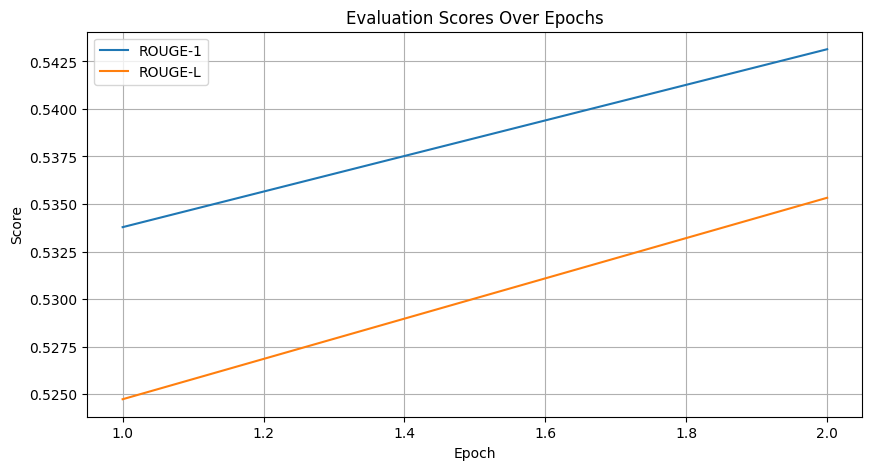

Model and tokenizer saved!


In [26]:
# Install dependencies
!pip uninstall -y torch torchvision torchaudio pandas fsspec gcsfs -q
!pip install torch torchvision torchaudio pandas transformers datasets nltk matplotlib evaluate rouge_score sentence-transformers -q
# Restart runtime after installation

import json
import pandas as pd
from datasets import Dataset, Features, Value
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
import evaluate
import matplotlib.pyplot as plt
import torch
import nltk
import numpy as np  # Added missing import
nltk.download('punkt')

# Verify setup
print(f"Torch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")

# Step 2: Download and load dataset
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json -O train-v1.1.json
with open('train-v1.1.json', 'r', encoding='utf-8') as f:
    squad_data = json.load(f)
print("Sample data:", squad_data['data'][0]['paragraphs'][0])

# Step 3: Clean and prepare dataset
data = []
for article in squad_data['data']:
    for paragraph in article['paragraphs']:
        context = paragraph['context'].strip()
        for qa in paragraph['qas']:
            question = qa['question'].strip()
            answer = qa['answers'][0]['text'].strip() if qa['answers'] else ""
            if context and question and answer:
                data.append({"context": context, "question": question, "answer": answer})

data = data[:800]
df = pd.DataFrame(data)
features = Features({
    "context": Value("string"),
    "question": Value("string"),
    "answer": Value("string")
})
dataset = Dataset.from_pandas(df, features=features)
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]
print(f"Train size: {len(train_dataset)} | Eval size: {len(eval_dataset)}")
print("First train example:", train_dataset[0])

# Step 4: Fine-tune the model
model_name = "valhalla/t5-small-qg-hl"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

def preprocess(examples):
    inputs = []
    for ctx, ans in zip(examples['context'], examples['answer']):
        if ans in ctx:
            highlighted = ctx.replace(ans, f"<hl> {ans} <hl>")
            inputs.append(f"generate question: {highlighted}")
        else:
            inputs.append(f"generate question: {ctx} <hl> {ans} <hl>")
    targets = examples['question']
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length", return_tensors=None)
    labels = tokenizer(targets, max_length=32, truncation=True, padding="max_length")["input_ids"]
    model_inputs["labels"] = labels
    return model_inputs

tokenized_train_dataset = train_dataset.map(preprocess, remove_columns=train_dataset.column_names, batched=True)
tokenized_eval_dataset = eval_dataset.map(preprocess, remove_columns=eval_dataset.column_names, batched=True)

tokenized_train_dataset = tokenized_train_dataset.with_format("torch")
tokenized_eval_dataset = tokenized_eval_dataset.with_format("torch")

training_args = TrainingArguments(
    output_dir="./qg-finetuned",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    eval_strategy="epoch",
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    save_total_limit=1,
    fp16=True,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions[0] if isinstance(predictions, tuple) else predictions
    predictions = np.argmax(predictions, axis=-1) if predictions.ndim == 3 else predictions
    labels = np.argmax(labels, axis=-1) if labels.ndim == 3 else labels

    def decode_sequences(sequences):
        return [tokenizer.decode(seq, skip_special_tokens=True) for seq in sequences]

    decoded_preds = decode_sequences(predictions)
    decoded_labels = decode_sequences(labels)

    rouge = evaluate.load("rouge")
    rouge_score = rouge.compute(predictions=decoded_preds, references=decoded_labels)

    return {
        "rouge1": rouge_score["rouge1"],
        "rougeL": rouge_score["rougeL"]
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    compute_metrics=compute_metrics
)

print("Fine-tuning started...")
trainer.train()
print("Running final evaluation...")
results = trainer.evaluate()
print("Final Evaluation Results:")
for metric, score in results.items():
    print(f"  {metric}: {score}")

# Step 5: Generate and evaluate sample questions
from transformers import GenerationConfig
model.eval()
sample = eval_dataset[0]
inputs = tokenizer(f"generate question: {sample['context']} {sample['answer']}", max_length=256, truncation=True, padding="max_length", return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

generation_config = GenerationConfig(early_stopping=True, num_beams=5, max_length=128)  # Adjusted
outputs = model.generate(**inputs, generation_config=generation_config)
generated_question = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Context: {sample['context'][:100]}...")
print(f"Answer: {sample['answer']}")
print(f"Generated Question: {generated_question}")
print(f"Reference Question: {sample['question']}")

# Step 6: Plot evaluation scores
log_history = trainer.state.log_history
epochs = [entry['epoch'] for entry in log_history if 'eval_rouge1' in entry]
rouge1_scores = [entry['eval_rouge1'] for entry in log_history if 'eval_rouge1' in entry]
rougeL_scores = [entry['eval_rougeL'] for entry in log_history if 'eval_rougeL' in entry]

plt.figure(figsize=(10, 5))
plt.plot(epochs, rouge1_scores, label='ROUGE-1')
plt.plot(epochs, rougeL_scores, label='ROUGE-L')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Scores Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Step 7: Save the model
model.save_pretrained("./qg-finetuned/final")
tokenizer.save_pretrained("./qg-finetuned/final")
print("Model and tokenizer saved!")

In [32]:
from tqdm import tqdm

decoded_preds = []
decoded_refs = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

for i, sample in enumerate(tqdm(eval_dataset)):
    if sample["answer"] in sample["context"]:
        highlighted_context = sample["context"].replace(sample["answer"], f"<hl> {sample['answer']} <hl>")
    else:
        highlighted_context = sample["context"] + f" <hl> {sample['answer']} <hl>"

    input_text = f"generate question: {highlighted_context}"
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=256
    ).to(device)

    output_ids = model.generate(
        **inputs,
        max_length=64,
        num_beams=4,
        early_stopping=False,  # <— loosen this up for now
        no_repeat_ngram_size=2
    )

    # 🪵 Debug print
    print(f"\n--- Sample {i + 1} ---")
    print("Raw token IDs:", output_ids[0].tolist())

    decoded_pred = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print("Decoded Prediction:", decoded_pred)

    decoded_preds.append(decoded_pred)
    decoded_refs.append(sample["question"])



  1%|          | 1/160 [00:00<01:21,  1.94it/s]


--- Sample 1 ---
Raw token IDs: [0, 571, 307, 410, 10846, 7, 582, 2753, 13, 7711, 3, 17084, 58, 1]
Decoded Prediction: How long did Burns become president of Notre Dame?


  1%|▏         | 2/160 [00:01<02:41,  1.02s/it]


--- Sample 2 ---
Raw token IDs: [0, 0, 2645, 2832, 24, 493, 63, 14549, 65, 582, 3, 9, 26159, 3, 7, 994, 6083, 437, 8, 1576, 13, 2744, 1304, 11937, 16, 2129, 58, 1]
Decoded Prediction: Who wrote that Beyonce has become a crossover sex symbol since the release of Dangerously in Love?


  2%|▏         | 3/160 [00:02<02:39,  1.01s/it]


--- Sample 3 ---
Raw token IDs: [0, 493, 63, 14549, 47, 8, 166, 3850, 18, 8778, 2377, 12, 1189, 8, 1600, 962, 13, 125, 3835, 58, 1]
Decoded Prediction: Beyonce was the first African-American artist to cover the September issue of what magazine?


  2%|▎         | 4/160 [00:03<02:28,  1.05it/s]


--- Sample 4 ---
Raw token IDs: [0, 0, 363, 47, 493, 63, 14549, 31, 7, 166, 6729, 2306, 1883, 30, 1515, 14320, 3888, 58, 1]
Decoded Prediction: What was Beyonce's first solo album released on June 24, 2003?


  3%|▎         | 5/160 [00:04<02:16,  1.14it/s]


--- Sample 5 ---
Raw token IDs: [0, 0, 2645, 410, 493, 63, 106, 75, 154, 20111, 30, 1186, 6464, 2628, 58, 1]
Decoded Prediction: Who did Beyoncé marry on April 4, 2008?


  4%|▍         | 6/160 [00:05<02:00,  1.28it/s]


--- Sample 6 ---
Raw token IDs: [0, 363, 410, 25219, 5530, 493, 63, 106, 75, 154, 38, 58, 1]
Decoded Prediction: What did Reid describe Beyoncé as?


  4%|▍         | 7/160 [00:06<02:23,  1.07it/s]


--- Sample 7 ---
Raw token IDs: [0, 363, 19, 8, 564, 13, 8, 126, 6198, 21, 1076, 44, 8, 3137, 26, 13277, 1888, 13, 1769, 5408, 2855, 1775, 58, 1]
Decoded Prediction: What is the name of the new residence for men at the Mendoza College of Business Executive Education Department?


  5%|▌         | 8/160 [00:07<02:10,  1.17it/s]


--- Sample 8 ---
Raw token IDs: [0, 363, 19, 8, 564, 13, 8, 1193, 18301, 257, 13, 6679, 4737, 58, 1]
Decoded Prediction: What is the name of the Congregation of Holy Cross?


  6%|▌         | 9/160 [00:07<01:54,  1.32it/s]


--- Sample 9 ---
Raw token IDs: [0, 0, 2645, 410, 493, 63, 14549, 20111, 58, 1]
Decoded Prediction: Who did Beyonce marry?


  6%|▋         | 10/160 [00:08<02:19,  1.07it/s]


--- Sample 10 ---
Raw token IDs: [0, 0, 363, 19, 8, 564, 13, 8, 814, 24, 493, 63, 106, 75, 154, 3, 29029, 16, 58, 1]
Decoded Prediction: What is the name of the film that Beyoncé starred in?


  7%|▋         | 11/160 [00:09<02:19,  1.07it/s]


--- Sample 11 ---
Raw token IDs: [0, 0, 2645, 410, 493, 63, 106, 75, 154, 1320, 46, 539, 2068, 21, 16, 1230, 58, 1]
Decoded Prediction: Who did Beyoncé sign an open letter for in 2015?


  8%|▊         | 12/160 [00:11<02:33,  1.04s/it]


--- Sample 12 ---
Raw token IDs: [0, 571, 231, 410, 8, 3819, 13, 7711, 3, 17084, 11, 3526, 5412, 1211, 726, 21, 70, 7117, 7, 58, 1]
Decoded Prediction: How much did the university of Notre Dame and Under Armour pay for their uniforms?


  8%|▊         | 13/160 [00:12<02:39,  1.09s/it]


--- Sample 13 ---
Raw token IDs: [0, 2840, 405, 7711, 3, 17084, 31, 7, 3, 867, 16528, 372, 5978, 58, 1]
Decoded Prediction: Where does Notre Dame's ice hockey team compete?


  9%|▉         | 14/160 [00:13<02:26,  1.00s/it]


--- Sample 14 ---
Raw token IDs: [0, 0, 363, 2324, 410, 493, 63, 106, 75, 154, 1912, 44, 8, 2464, 13074, 3, 30634, 58, 1]
Decoded Prediction: What song did Beyoncé perform at the 2009 presidential inauguration?


  9%|▉         | 15/160 [00:13<02:04,  1.16it/s]


--- Sample 15 ---
Raw token IDs: [0, 571, 186, 8167, 410, 272, 31, 16803, 1789, 16, 165, 166, 471, 58, 1]
Decoded Prediction: How many copies did B'Day sell in its first week?


 10%|█         | 16/160 [00:14<01:46,  1.35it/s]


--- Sample 16 ---
Raw token IDs: [0, 363, 19, 411, 31, 10499, 18819, 655, 63, 2501, 31, 7, 3595, 358, 58, 1]
Decoded Prediction: What is O'Shaughnessy Hall's library system?


 11%|█         | 17/160 [00:14<01:39,  1.43it/s]


--- Sample 17 ---
Raw token IDs: [0, 0, 571, 231, 410, 493, 63, 14549, 1492, 30, 160, 166, 4219, 1552, 16, 4101, 58, 1]
Decoded Prediction: How much did Beyonce spend on her first concert tour in 2007?


 11%|█▏        | 18/160 [00:16<02:11,  1.08it/s]


--- Sample 18 ---
Raw token IDs: [0, 571, 186, 12321, 410, 8, 991, 712, 96, 308, 154, 354, 85, 584, 76, 121, 1535, 30, 8, 3259, 1976, 5396, 910, 5059, 58, 1]
Decoded Prediction: How many charts did the lead single "Déjà Vu" reach on the Billboard Hot 100 chart?


 12%|█▏        | 19/160 [00:16<01:53,  1.24it/s]


--- Sample 19 ---
Raw token IDs: [0, 0, 363, 605, 410, 493, 63, 14549, 11, 9373, 18, 956, 2467, 16, 1718, 2038, 58, 1]
Decoded Prediction: What event did Beyonce and Jay-Z attend in July 2013?


 12%|█▎        | 20/160 [00:16<01:29,  1.56it/s]


--- Sample 20 ---
Raw token IDs: [0, 0, 363, 47, 493, 63, 14549, 31, 7, 166, 6922, 1075, 16, 3581, 58, 1]
Decoded Prediction: What was Beyonce's first acting role in 2006?


 13%|█▎        | 21/160 [00:17<01:18,  1.76it/s]


--- Sample 21 ---
Raw token IDs: [0, 366, 410, 493, 63, 14549, 6456, 3, 9, 7102, 144, 302, 45, 160, 723, 1415, 58, 1]
Decoded Prediction: When did Beyonce announce a hiatus from her music career?


 14%|█▍        | 22/160 [00:17<01:14,  1.85it/s]


--- Sample 22 ---
Raw token IDs: [0, 0, 571, 231, 410, 493, 63, 106, 75, 154, 31, 7, 6922, 1075, 16, 37, 12070, 21149, 8690, 44, 8, 1367, 828, 4388, 58, 1]
Decoded Prediction: How much did Beyoncé's acting role in The Pink Panther gross at the box office worldwide?


 14%|█▍        | 23/160 [00:18<01:01,  2.24it/s]


--- Sample 23 ---
Raw token IDs: [0, 571, 186, 203, 47, 8, 4543, 13, 14984, 7, 8307, 58, 1]
Decoded Prediction: How many years was the Review of Politics edited?


 15%|█▌        | 24/160 [00:18<00:54,  2.47it/s]


--- Sample 24 ---
Raw token IDs: [0, 0, 363, 686, 13, 3800, 410, 493, 63, 106, 75, 154, 31, 7, 778, 3605, 560, 58, 1]
Decoded Prediction: What type of theme did Beyoncé's early songs include?


 16%|█▌        | 25/160 [00:18<00:48,  2.79it/s]


--- Sample 25 ---
Raw token IDs: [0, 363, 19, 8, 564, 13, 8, 4467, 13, 2330, 15848, 58, 1]
Decoded Prediction: What is the name of the Word of Life mural?


 16%|█▋        | 26/160 [00:19<00:49,  2.72it/s]


--- Sample 26 ---
Raw token IDs: [0, 0, 86, 125, 203, 410, 2900, 570, 493, 63, 106, 75, 154, 859, 8, 910, 167, 16569, 151, 16, 8, 296, 58, 1]
Decoded Prediction: In what years did Time list Beyoncé among the 100 most influential people in the world?


 17%|█▋        | 27/160 [00:19<00:45,  2.95it/s]


--- Sample 27 ---
Raw token IDs: [0, 571, 186, 2061, 43, 751, 8, 1076, 31, 7, 8498, 372, 58, 1]
Decoded Prediction: How many schools have won the men's basketball team?


 18%|█▊        | 28/160 [00:19<00:45,  2.88it/s]


--- Sample 28 ---
Raw token IDs: [0, 0, 363, 3295, 410, 3259, 1976, 3835, 570, 493, 63, 106, 75, 154, 30, 16, 2722, 58, 1]
Decoded Prediction: What category did Billboard magazine list Beyoncé on in 2011?


 18%|█▊        | 29/160 [00:20<00:47,  2.77it/s]


--- Sample 29 ---
Raw token IDs: [0, 0, 363, 19, 8, 564, 13, 8, 283, 5, 21313, 5, 478, 1860, 57, 8, 1888, 13, 4218, 11, 8706, 7, 58, 1]
Decoded Prediction: What is the name of the M.Div. program offered by the College of Arts and Letters?


 19%|█▉        | 30/160 [00:20<00:49,  2.61it/s]


--- Sample 30 ---
Raw token IDs: [0, 571, 186, 8167, 410, 493, 63, 106, 75, 154, 1789, 16, 165, 166, 471, 58, 1]
Decoded Prediction: How many copies did Beyoncé sell in its first week?


 19%|█▉        | 31/160 [00:20<00:45,  2.83it/s]


--- Sample 31 ---
Raw token IDs: [0, 0, 2645, 410, 493, 63, 14549, 2249, 16, 24692, 58, 1]
Decoded Prediction: Who did Beyonce voice in Epic?


 20%|██        | 32/160 [00:21<00:49,  2.59it/s]


--- Sample 32 ---
Raw token IDs: [0, 0, 363, 1900, 410, 216, 7289, 107, 11, 7711, 3, 17084, 1344, 3, 9, 576, 18, 994, 13073, 478, 58, 1]
Decoded Prediction: What college did Hesburgh and Notre Dame develop a co-exchange program?


 21%|██        | 33/160 [00:21<00:47,  2.67it/s]


--- Sample 33 ---
Raw token IDs: [0, 0, 363, 1552, 410, 493, 63, 106, 75, 154, 17046, 30, 16, 1740, 16, 1671, 3888, 58, 1]
Decoded Prediction: What tour did Beyoncé embark on in Europe in November 2003?


 21%|██▏       | 34/160 [00:21<00:47,  2.65it/s]


--- Sample 34 ---
Raw token IDs: [0, 0, 363, 47, 493, 63, 14549, 31, 7, 166, 6729, 1368, 30, 8, 3259, 1976, 5396, 910, 5059, 58, 1]
Decoded Prediction: What was Beyonce's first solo record on the Billboard Hot 100 chart?


 22%|██▏       | 35/160 [00:22<00:45,  2.76it/s]


--- Sample 35 ---
Raw token IDs: [0, 0, 2645, 410, 493, 63, 106, 75, 154, 11872, 887, 12, 1716, 38, 16, 8, 350, 940, 58, 1]
Decoded Prediction: Who did Beyoncé urge women to serve as in the G7?


 22%|██▎       | 36/160 [00:22<00:50,  2.47it/s]


--- Sample 36 ---
Raw token IDs: [0, 571, 186, 10657, 7, 399, 1962, 410, 19344, 63, 31, 7, 9364, 1912, 44, 8, 2011, 9713, 3, 4, 15086, 196, 196, 985, 715, 504, 58, 1]
Decoded Prediction: How many tweets per minute did Destiny's Child perform at the Super Bowl XLVII halftime show?


 23%|██▎       | 37/160 [00:23<00:46,  2.67it/s]


--- Sample 37 ---
Raw token IDs: [0, 2840, 410, 493, 63, 106, 75, 154, 2467, 13156, 18867, 1121, 58, 1]
Decoded Prediction: Where did Beyoncé attend Parker Elementary School?


 24%|██▍       | 38/160 [00:23<00:50,  2.43it/s]


--- Sample 38 ---
Raw token IDs: [0, 0, 363, 19, 8, 564, 13, 3, 9, 2324, 16, 272, 31, 16803, 58, 1]
Decoded Prediction: What is the name of a song in B'Day?


 24%|██▍       | 39/160 [00:24<00:50,  2.40it/s]


--- Sample 39 ---
Raw token IDs: [0, 0, 2645, 12566, 493, 63, 106, 75, 154, 31, 7, 5739, 11, 3, 2998, 1999, 38, 11562, 58, 1]
Decoded Prediction: Who highlighted Beyoncé's tone and timbre as distinctive?


 25%|██▌       | 40/160 [00:24<00:49,  2.45it/s]


--- Sample 40 ---
Raw token IDs: [0, 4073, 3819, 65, 8, 167, 216, 159, 348, 21361, 107, 725, 751, 58, 1]
Decoded Prediction: Which university has the most Heisman Trophies won?


 26%|██▌       | 41/160 [00:24<00:51,  2.32it/s]


--- Sample 41 ---
Raw token IDs: [0, 0, 363, 2324, 410, 9373, 1027, 1576, 30, 2330, 232, 715, 7, 5, 287, 58, 1]
Decoded Prediction: What song did Jay Z release on Lifeandtimes.com?


 26%|██▋       | 42/160 [00:25<00:55,  2.14it/s]


--- Sample 42 ---
Raw token IDs: [0, 0, 571, 186, 13569, 410, 493, 63, 14549, 43, 44, 8, 2722, 283, 4562, 3953, 3057, 6580, 58, 1]
Decoded Prediction: How many viewers did Beyonce have at the 2011 MTV Video Music Awards?


 27%|██▋       | 43/160 [00:25<00:51,  2.25it/s]


--- Sample 43 ---
Raw token IDs: [0, 363, 8468, 405, 59, 43, 3, 9, 6040, 8815, 42, 14829, 21913, 45, 7711, 3, 17084, 58, 1]
Decoded Prediction: What newspaper does not have a faculty advisor or editorial oversight from Notre Dame?


 28%|██▊       | 44/160 [00:26<00:53,  2.16it/s]


--- Sample 44 ---
Raw token IDs: [0, 0, 2645, 2832, 24, 493, 63, 14549, 65, 582, 3, 9, 26159, 3, 7, 994, 6083, 437, 8, 1576, 13, 2744, 1304, 11937, 16, 2129, 58, 1]
Decoded Prediction: Who wrote that Beyonce has become a crossover sex symbol since the release of Dangerously in Love?


 28%|██▊       | 45/160 [00:26<00:48,  2.35it/s]


--- Sample 45 ---
Raw token IDs: [0, 0, 363, 686, 13, 3, 7, 994, 3958, 65, 493, 63, 14549, 118, 3028, 38, 58, 1]
Decoded Prediction: What type of sex appeal has Beyonce been described as?


 29%|██▉       | 46/160 [00:26<00:45,  2.53it/s]


--- Sample 46 ---
Raw token IDs: [0, 0, 363, 3066, 47, 6946, 1079, 1660, 630, 4904, 107, 51, 638, 18, 23620, 127, 13, 58, 1]
Decoded Prediction: What department was Father John Augustine Zahm Co-Director of?


 29%|██▉       | 47/160 [00:27<00:43,  2.58it/s]


--- Sample 47 ---
Raw token IDs: [0, 0, 2645, 410, 493, 63, 106, 75, 154, 11872, 887, 12, 1716, 38, 16, 8, 350, 940, 58, 1]
Decoded Prediction: Who did Beyoncé urge women to serve as in the G7?


 30%|███       | 48/160 [00:27<00:41,  2.67it/s]


--- Sample 48 ---
Raw token IDs: [0, 0, 363, 47, 8, 564, 13, 493, 63, 14549, 31, 7, 511, 6729, 2306, 58, 1]
Decoded Prediction: What was the name of Beyonce's second solo album?


 31%|███       | 49/160 [00:28<00:41,  2.70it/s]


--- Sample 49 ---
Raw token IDs: [0, 366, 410, 493, 63, 106, 75, 154, 497, 24, 5428, 15822, 3555, 160, 12, 240, 610, 13, 160, 1415, 58, 1]
Decoded Prediction: When did Beyoncé say that Madonna inspired her to take control of her career?


 31%|███▏      | 50/160 [00:28<00:38,  2.86it/s]


--- Sample 50 ---
Raw token IDs: [0, 0, 363, 4183, 12373, 410, 493, 63, 106, 75, 154, 577, 1414, 6073, 16, 16, 3888, 58, 1]
Decoded Prediction: What musical comedy did Beyoncé play Lilly in in 2003?


 32%|███▏      | 51/160 [00:28<00:35,  3.10it/s]


--- Sample 51 ---
Raw token IDs: [0, 2645, 5105, 2691, 81, 493, 63, 106, 75, 154, 58, 1]
Decoded Prediction: Who obtained documents about Beyoncé?


 32%|███▎      | 52/160 [00:28<00:35,  3.03it/s]


--- Sample 52 ---
Raw token IDs: [0, 0, 363, 47, 493, 63, 14549, 31, 7, 4509, 712, 3, 9, 1328, 1269, 16, 8, 837, 58, 1]
Decoded Prediction: What was Beyonce's fourth single a commercial success in the US?


 33%|███▎      | 53/160 [00:29<00:35,  2.99it/s]


--- Sample 53 ---
Raw token IDs: [0, 366, 47, 7155, 3, 19003, 1790, 58, 1]
Decoded Prediction: When was Common Sense published?


 34%|███▍      | 54/160 [00:29<00:33,  3.14it/s]


--- Sample 54 ---
Raw token IDs: [0, 0, 363, 405, 493, 63, 106, 75, 154, 114, 12, 3270, 30, 10705, 58, 1]
Decoded Prediction: What does Beyoncé like to dress onstage?


 34%|███▍      | 55/160 [00:29<00:35,  2.96it/s]


--- Sample 55 ---
Raw token IDs: [0, 2645, 47, 8, 1025, 2335, 30, 3259, 1976, 31, 7, 570, 13, 8, 2224, 460, 5396, 910, 11263, 12756, 7, 58, 1]
Decoded Prediction: Who was the third woman on Billboard's list of the Top 20 Hot 100 Songwriters?


 35%|███▌      | 56/160 [00:30<00:39,  2.66it/s]


--- Sample 56 ---
Raw token IDs: [0, 0, 2645, 410, 493, 63, 106, 75, 154, 1912, 30, 8, 1463, 96, 566, 63, 51, 29, 21, 8, 20418, 121, 58, 1]
Decoded Prediction: Who did Beyoncé perform on the track "Hymn for the Weekend"?


 36%|███▌      | 57/160 [00:30<00:41,  2.46it/s]


--- Sample 57 ---
Raw token IDs: [0, 571, 186, 14234, 410, 8, 991, 712, 96, 308, 154, 354, 85, 584, 76, 121, 1535, 30, 8, 3259, 1976, 5396, 910, 5059, 58, 1]
Decoded Prediction: How many albums did the lead single "Déjà Vu" reach on the Billboard Hot 100 chart?


 36%|███▋      | 58/160 [00:31<00:39,  2.61it/s]


--- Sample 58 ---
Raw token IDs: [0, 0, 571, 186, 13588, 7, 410, 493, 63, 14549, 911, 44, 8, 9065, 727, 7389, 26596, 6580, 58, 1]
Decoded Prediction: How many nominations did Beyonce receive at the 52nd Annual Grammy Awards?


 37%|███▋      | 59/160 [00:31<00:35,  2.88it/s]


--- Sample 59 ---
Raw token IDs: [0, 363, 2324, 410, 493, 63, 106, 75, 154, 1431, 21, 24692, 58, 1]
Decoded Prediction: What song did Beyoncé write for Epic?


 38%|███▊      | 60/160 [00:31<00:32,  3.12it/s]


--- Sample 60 ---
Raw token IDs: [0, 2645, 3555, 493, 63, 106, 75, 154, 58, 1]
Decoded Prediction: Who inspired Beyoncé?


 38%|███▊      | 61/160 [00:32<00:30,  3.28it/s]


--- Sample 61 ---
Raw token IDs: [0, 363, 47, 8, 2041, 585, 3135, 21, 7711, 3, 17084, 58, 1]
Decoded Prediction: What was the annual research funding for Notre Dame?


 39%|███▉      | 62/160 [00:32<00:27,  3.57it/s]


--- Sample 62 ---
Raw token IDs: [0, 2645, 1632, 8, 166, 797, 12, 1299, 3, 9, 5419, 1569, 58, 1]
Decoded Prediction: Who became the first American to send a wireless message?


 39%|███▉      | 63/160 [00:32<00:32,  3.00it/s]


--- Sample 63 ---
Raw token IDs: [0, 363, 13681, 19, 2425, 12, 585, 6, 1073, 11, 16866, 30, 8, 4110, 13, 9674, 4129, 11, 8, 1124, 21, 5086, 3065, 58, 1]
Decoded Prediction: What institute is dedicated to research, education and outreach on the causes of violent conflict and the conditions for sustainable peace?


 40%|████      | 64/160 [00:33<00:30,  3.10it/s]


--- Sample 64 ---
Raw token IDs: [0, 0, 2645, 751, 493, 63, 106, 75, 154, 31, 7, 2760, 21, 16182, 12559, 58, 1]
Decoded Prediction: Who won Beyoncé's award for Morning Phase?


 41%|████      | 65/160 [00:33<00:28,  3.28it/s]


--- Sample 65 ---
Raw token IDs: [0, 2645, 10626, 2765, 12, 6774, 8, 452, 3078, 3543, 58, 1]
Decoded Prediction: Who hired workers to construct the public parking garage?


 41%|████▏     | 66/160 [00:33<00:31,  2.97it/s]


--- Sample 66 ---
Raw token IDs: [0, 2645, 47, 8, 6342, 5, 37, 7512, 15, 283, 5, 216, 7289, 107, 205, 4112, 58, 1]
Decoded Prediction: Who was the Rev. Theodore M. Hesburgh CSC?


 42%|████▏     | 67/160 [00:34<00:31,  2.91it/s]


--- Sample 67 ---
Raw token IDs: [0, 0, 2645, 1891, 493, 63, 14549, 8, 1867, 12, 619, 280, 6, 12, 36, 3555, 57, 378, 541, 58, 1]
Decoded Prediction: Who gave Beyonce the advice to live life, to be inspired by things again?


 42%|████▎     | 68/160 [00:34<00:30,  2.97it/s]


--- Sample 68 ---
Raw token IDs: [0, 0, 366, 47, 493, 63, 14549, 31, 7, 4509, 3100, 2306, 314, 1883, 58, 1]
Decoded Prediction: When was Beyonce's fourth studio album 4 released?


 43%|████▎     | 69/160 [00:34<00:31,  2.87it/s]


--- Sample 69 ---
Raw token IDs: [0, 461, 125, 833, 47, 1449, 13, 8, 325, 3809, 17, 444, 6341, 1166, 708, 58, 1]
Decoded Prediction: On what date was construction of the LaFortune Student Center started?


 44%|████▍     | 70/160 [00:34<00:28,  3.19it/s]


--- Sample 70 ---
Raw token IDs: [0, 2645, 1632, 819, 3763, 13, 7711, 3, 17084, 16, 21402, 58, 1]
Decoded Prediction: Who became head coach of Notre Dame in 1918?


 44%|████▍     | 71/160 [00:35<00:26,  3.42it/s]


--- Sample 71 ---
Raw token IDs: [0, 363, 19, 8, 711, 740, 13, 7711, 3, 17084, 31, 7, 3595, 58, 1]
Decoded Prediction: What is the main building of Notre Dame's library?


 45%|████▌     | 72/160 [00:35<00:29,  3.02it/s]


--- Sample 72 ---
Raw token IDs: [0, 363, 19, 8, 564, 13, 7711, 3, 17084, 58, 1]
Decoded Prediction: What is the name of Notre Dame?


 46%|████▌     | 73/160 [00:35<00:29,  2.98it/s]


--- Sample 73 ---
Raw token IDs: [0, 461, 125, 239, 56, 8, 15714, 5567, 31, 15697, 916, 58, 1]
Decoded Prediction: On what day will the Drummers' Circle continue?


 46%|████▋     | 74/160 [00:36<00:42,  2.03it/s]


--- Sample 74 ---
Raw token IDs: [0, 86, 1230, 18, 11505, 6, 125, 11003, 410, 7711, 3, 17084, 11003, 859, 96, 16557, 8278, 121, 16, 8, 412, 5, 134, 5, 3529, 3, 184, 1150, 3750, 31, 7, 1648, 1888, 7, 58, 1]
Decoded Prediction: In 2015-2016, what rank did Notre Dame rank among "national universities" in the U.S. News & World Report's Best Colleges?


 47%|████▋     | 75/160 [00:37<00:42,  1.98it/s]


--- Sample 75 ---
Raw token IDs: [0, 0, 486, 125, 605, 410, 493, 63, 106, 75, 154, 582, 8, 166, 3955, 2377, 12, 12392, 8, 30237, 1726, 58, 1]
Decoded Prediction: At what event did Beyoncé become the first female artist to headline the Pyramid stage?


 48%|████▊     | 76/160 [00:38<00:52,  1.59it/s]


--- Sample 76 ---
Raw token IDs: [0, 0, 493, 63, 14549, 11, 9373, 1027, 263, 34, 139, 8, 2846, 77, 655, 1150, 11547, 38, 8, 96, 6739, 222, 18, 2741, 29, 53, 579, 1158, 121, 21, 6018, 120, 12127, 1514, 3940, 770, 58, 1]
Decoded Prediction: Beyonce and Jay Z made it into the Guinness World Records as the "highest-earning power couple" for collectively earning $78 million?


 48%|████▊     | 77/160 [00:38<00:44,  1.87it/s]


--- Sample 77 ---
Raw token IDs: [0, 0, 363, 5349, 13, 3605, 410, 19344, 63, 31, 7, 9364, 1576, 2129, 18142, 58, 1]
Decoded Prediction: What genre of songs did Destiny's Child release Love Songs?


 49%|████▉     | 78/160 [00:39<00:41,  1.97it/s]


--- Sample 78 ---
Raw token IDs: [0, 0, 2645, 410, 493, 63, 106, 75, 154, 582, 8, 166, 3850, 18, 8778, 2335, 12, 43, 913, 11893, 30, 386, 381, 80, 3605, 58, 1]
Decoded Prediction: Who did Beyoncé become the first African-American woman to have writing credits on three number one songs?


 49%|████▉     | 79/160 [00:39<00:36,  2.20it/s]


--- Sample 79 ---
Raw token IDs: [0, 571, 186, 13588, 7, 410, 493, 63, 14549, 911, 44, 8, 9065, 727, 7389, 26596, 6580, 58, 1]
Decoded Prediction: How many nominations did Beyonce receive at the 52nd Annual Grammy Awards?


 50%|█████     | 80/160 [00:39<00:36,  2.19it/s]


--- Sample 80 ---
Raw token IDs: [0, 2645, 2681, 493, 63, 106, 75, 154, 44, 381, 80, 30, 160, 570, 13, 8, 9528, 1648, 24366, 87, 308, 663, 52, 7, 58, 1]
Decoded Prediction: Who placed Beyoncé at number one on her list of the Five Best Singer/Dancers?


 51%|█████     | 81/160 [00:40<00:32,  2.40it/s]


--- Sample 81 ---
Raw token IDs: [0, 0, 363, 19, 8, 564, 13, 411, 31, 10499, 18819, 655, 63, 2501, 58, 1]
Decoded Prediction: What is the name of O'Shaughnessy Hall?


 51%|█████▏    | 82/160 [00:40<00:28,  2.73it/s]


--- Sample 82 ---
Raw token IDs: [0, 0, 363, 47, 8, 167, 7533, 6878, 16, 283, 4562, 892, 58, 1]
Decoded Prediction: What was the most watched broadcast in MTV history?


 52%|█████▏    | 83/160 [00:40<00:29,  2.63it/s]


--- Sample 83 ---
Raw token IDs: [0, 363, 2760, 410, 493, 63, 106, 75, 154, 911, 45, 8, 368, 1060, 2125, 13, 1589, 3559, 343, 7, 58, 1]
Decoded Prediction: What award did Beyoncé receive from the New York Association of Black Journalists?


 52%|█████▎    | 84/160 [00:41<00:29,  2.59it/s]


--- Sample 84 ---
Raw token IDs: [0, 0, 571, 231, 410, 8513, 2621, 7, 16, 2540, 12066, 16917, 16, 4407, 58, 1]
Decoded Prediction: How much did Austin Powers in Goldmember grosse in 2002?


 53%|█████▎    | 85/160 [00:41<00:26,  2.80it/s]


--- Sample 85 ---
Raw token IDs: [0, 363, 19, 8, 564, 13, 7711, 3, 17084, 31, 7, 1449, 516, 58, 1]
Decoded Prediction: What is the name of Notre Dame's construction project?


 54%|█████▍    | 86/160 [00:41<00:24,  3.03it/s]


--- Sample 86 ---
Raw token IDs: [0, 363, 47, 493, 63, 14549, 31, 7, 166, 4219, 1552, 58, 1]
Decoded Prediction: What was Beyonce's first concert tour?


 54%|█████▍    | 87/160 [00:42<00:23,  3.05it/s]


--- Sample 87 ---
Raw token IDs: [0, 0, 2645, 1940, 8, 3567, 12, 112, 5961, 1826, 3100, 11, 2681, 135, 16, 2042, 4769, 58, 1]
Decoded Prediction: Who brought the girls to his Northern California studio and placed them in Star Search?


 55%|█████▌    | 88/160 [00:42<00:24,  2.97it/s]


--- Sample 88 ---
Raw token IDs: [0, 363, 47, 8, 564, 13, 8, 723, 6358, 44, 325, 3809, 17, 444, 58, 1]
Decoded Prediction: What was the name of the music hall at LaFortune?


 56%|█████▌    | 89/160 [00:42<00:22,  3.10it/s]


--- Sample 89 ---
Raw token IDs: [0, 363, 3066, 13, 8, 1888, 13, 2854, 405, 59, 462, 10360, 1356, 58, 1]
Decoded Prediction: What department of the College of Science does not offer PhD programs?


 56%|█████▋    | 90/160 [00:43<00:23,  2.98it/s]


--- Sample 90 ---
Raw token IDs: [0, 0, 363, 47, 8, 564, 13, 19344, 63, 31, 7, 9364, 22, 7, 167, 1574, 2324, 44, 8, 97, 58, 1]
Decoded Prediction: What was the name of Destiny's Child’s most successful song at the time?


 57%|█████▋    | 91/160 [00:43<00:25,  2.75it/s]


--- Sample 91 ---
Raw token IDs: [0, 363, 47, 493, 63, 106, 75, 154, 31, 7, 11592, 16, 8, 5777, 11263, 12756, 13, 8, 2929, 2760, 58, 1]
Decoded Prediction: What was Beyoncé's ranking in the Pop Songwriter of the Year award?


 57%|█████▊    | 92/160 [00:43<00:25,  2.68it/s]


--- Sample 92 ---
Raw token IDs: [0, 366, 47, 8, 1657, 96, 279, 32, 32, 17, 63, 2176, 2936, 121, 974, 12, 8, 10274, 1566, 28767, 58, 1]
Decoded Prediction: When was the term "Bootylicious" added to the Oxford English Dictionary?


 58%|█████▊    | 93/160 [00:44<00:25,  2.63it/s]


--- Sample 93 ---
Raw token IDs: [0, 0, 571, 186, 2456, 410, 493, 63, 106, 75, 154, 911, 45, 6800, 7, 16, 37, 30979, 3, 15291, 17, 1628, 58, 1]
Decoded Prediction: How many reviews did Beyoncé receive from critics in The Fighting Temptations?


 59%|█████▉    | 94/160 [00:44<00:25,  2.63it/s]


--- Sample 94 ---
Raw token IDs: [0, 0, 493, 63, 106, 75, 154, 47, 2616, 859, 8, 910, 167, 16569, 151, 16, 8, 296, 16, 2038, 11, 1412, 58, 1]
Decoded Prediction: Beyoncé was listed among the 100 most influential people in the world in 2013 and 2014?


 59%|█████▉    | 95/160 [00:45<00:23,  2.73it/s]


--- Sample 95 ---
Raw token IDs: [0, 0, 2840, 410, 8, 9058, 29, 43, 3, 9, 471, 18, 2961, 9058, 624, 29, 58, 1]
Decoded Prediction: Where did the Klan have a week-long Klavern?


 60%|██████    | 96/160 [00:45<00:24,  2.63it/s]


--- Sample 96 ---
Raw token IDs: [0, 571, 186, 5128, 410, 493, 63, 106, 75, 154, 17046, 30, 8, 8667, 5, 17080, 3111, 1150, 3351, 58, 1]
Decoded Prediction: How many dates did Beyoncé embark on the Mrs. Carter Show World Tour?


 61%|██████    | 97/160 [00:45<00:22,  2.75it/s]


--- Sample 97 ---
Raw token IDs: [0, 2840, 19, 8, 23711, 2617, 13, 8, 3, 24756, 6219, 1069, 58, 1]
Decoded Prediction: Where is the Basilica of the Sacred Heart located?


 61%|██████▏   | 98/160 [00:46<00:24,  2.56it/s]


--- Sample 98 ---
Raw token IDs: [0, 4073, 3835, 2616, 493, 63, 14549, 38, 381, 1003, 30, 70, 570, 13, 8, 96, 22481, 460, 5396, 910, 11263, 12756, 7, 121, 58, 1]
Decoded Prediction: Which magazine listed Beyonce as number 17 on their list of the "Top 20 Hot 100 Songwriters"?


 62%|██████▏   | 99/160 [00:46<00:23,  2.57it/s]


--- Sample 99 ---
Raw token IDs: [0, 363, 47, 8, 564, 13, 19344, 63, 31, 7, 9364, 58, 1]
Decoded Prediction: What was the name of Destiny's Child?


 62%|██████▎   | 100/160 [00:46<00:22,  2.71it/s]


--- Sample 100 ---
Raw token IDs: [0, 0, 363, 1657, 410, 8, 783, 557, 169, 12, 5530, 493, 63, 106, 75, 154, 58, 1]
Decoded Prediction: What term did the media often use to describe Beyoncé?


 63%|██████▎   | 101/160 [00:47<00:21,  2.79it/s]


--- Sample 101 ---
Raw token IDs: [0, 0, 363, 47, 8, 564, 13, 8, 23739, 261, 57, 6248, 5, 29295, 58, 1]
Decoded Prediction: What was the name of the chapel used by Fr. Sorin?


 64%|██████▍   | 102/160 [00:47<00:19,  2.96it/s]


--- Sample 102 ---
Raw token IDs: [0, 571, 186, 203, 410, 8, 7262, 1369, 386, 1157, 10183, 7, 58, 1]
Decoded Prediction: How many years did the Irish win three national championships?


 64%|██████▍   | 103/160 [00:47<00:17,  3.19it/s]


--- Sample 103 ---
Raw token IDs: [0, 86, 125, 484, 47, 19344, 63, 31, 7, 9364, 3, 390, 58, 1]
Decoded Prediction: In what book was Destiny's Child based?


 65%|██████▌   | 104/160 [00:48<00:18,  3.02it/s]


--- Sample 104 ---
Raw token IDs: [0, 366, 19, 7711, 3, 17084, 234, 12, 8, 3699, 3, 14808, 257, 11507, 58, 1]
Decoded Prediction: When is Notre Dame home to the Global Adaptation Index?


 66%|██████▌   | 105/160 [00:48<00:19,  2.87it/s]


--- Sample 105 ---
Raw token IDs: [0, 571, 186, 481, 5526, 7711, 3, 17084, 16, 1412, 58, 1]
Decoded Prediction: How many students attended Notre Dame in 2014?


 66%|██████▋   | 106/160 [00:49<00:20,  2.64it/s]


--- Sample 106 ---
Raw token IDs: [0, 0, 363, 1974, 410, 493, 63, 106, 75, 154, 1912, 44, 8, 166, 1158, 31, 7, 166, 22145, 1996, 58, 1]
Decoded Prediction: What movie did Beyoncé perform at the first couple's first inaugural ball?


 67%|██████▋   | 107/160 [00:49<00:22,  2.40it/s]


--- Sample 107 ---
Raw token IDs: [0, 2645, 3977, 227, 493, 63, 106, 75, 154, 11, 9373, 18, 956, 1736, 28, 112, 384, 58, 1]
Decoded Prediction: Who died after Beyoncé and Jay-Z met with his family?


 68%|██████▊   | 108/160 [00:49<00:22,  2.36it/s]


--- Sample 108 ---
Raw token IDs: [0, 0, 363, 410, 493, 63, 106, 75, 154, 497, 5428, 15822, 3555, 160, 58, 1]
Decoded Prediction: What did Beyoncé say Madonna inspired her?


 68%|██████▊   | 109/160 [00:50<00:22,  2.23it/s]


--- Sample 109 ---
Raw token IDs: [0, 0, 366, 410, 493, 63, 14549, 1576, 2744, 1304, 11937, 16, 2129, 58, 1]
Decoded Prediction: When did Beyonce release Dangerously in Love?


 69%|██████▉   | 110/160 [00:50<00:21,  2.29it/s]


--- Sample 110 ---
Raw token IDs: [0, 0, 571, 186, 3187, 65, 493, 63, 106, 75, 154, 1916, 28, 19344, 63, 31, 7, 9364, 58, 1]
Decoded Prediction: How many records has Beyoncé sold with Destiny's Child?


 69%|██████▉   | 111/160 [00:51<00:20,  2.37it/s]


--- Sample 111 ---
Raw token IDs: [0, 37, 8026, 49, 1166, 21, 5408, 2855, 19, 1069, 3414, 13, 8, 3137, 26, 13277, 1888, 13, 1769, 4297, 1073, 3066, 58, 1]
Decoded Prediction: The Stayer Center for Executive Education is located south of the Mendoza College of Business executive education department?


 70%|███████   | 112/160 [00:51<00:18,  2.65it/s]


--- Sample 112 ---
Raw token IDs: [0, 2645, 1192, 325, 3809, 17, 444, 1166, 58, 1]
Decoded Prediction: Who built LaFortune Center?


 71%|███████   | 113/160 [00:51<00:16,  2.91it/s]


--- Sample 113 ---
Raw token IDs: [0, 2645, 3, 28285, 26, 120, 4283, 12, 8, 16823, 3790, 16, 507, 3449, 58, 1]
Decoded Prediction: Who reputedly appeared to the Virgin Mary in 1858?


 71%|███████▏  | 114/160 [00:52<00:16,  2.82it/s]


--- Sample 114 ---
Raw token IDs: [0, 0, 2840, 410, 493, 63, 106, 75, 154, 11, 9373, 1027, 281, 12, 12, 4279, 8, 2306, 1189, 21, 160, 314, 58, 1]
Decoded Prediction: Where did Beyoncé and Jay Z go to to shoot the album cover for her 4?


 72%|███████▏  | 115/160 [00:52<00:17,  2.62it/s]


--- Sample 115 ---
Raw token IDs: [0, 0, 2645, 1012, 1601, 8, 1657, 96, 279, 32, 32, 17, 63, 2176, 2936, 121, 12, 5530, 493, 63, 14549, 58, 1]
Decoded Prediction: Who popularized the term "Bootylicious" to describe Beyonce?


 72%|███████▎  | 116/160 [00:52<00:14,  2.99it/s]


--- Sample 116 ---
Raw token IDs: [0, 363, 2953, 186, 6502, 8445, 7, 12, 8079, 15, 1740, 58, 1]
Decoded Prediction: What caused many Catholic intellectuals to flee Europe?


 73%|███████▎  | 117/160 [00:53<00:12,  3.32it/s]


--- Sample 117 ---
Raw token IDs: [0, 363, 19, 8, 564, 13, 8, 2854, 2501, 58, 1]
Decoded Prediction: What is the name of the Science Hall?


 74%|███████▍  | 118/160 [00:53<00:13,  3.11it/s]


--- Sample 118 ---
Raw token IDs: [0, 363, 47, 8, 564, 13, 8, 8131, 10626, 57, 8, 896, 13, 1013, 22435, 12, 6774, 262, 8155, 1887, 7155, 7, 58, 1]
Decoded Prediction: What was the name of the contractor hired by the City of South Bend to construct Eddy Street Commons?


 74%|███████▍  | 119/160 [00:53<00:13,  3.15it/s]


--- Sample 119 ---
Raw token IDs: [0, 0, 2645, 130, 493, 63, 106, 75, 154, 31, 7, 5487, 8705, 12, 58, 1]
Decoded Prediction: Who were Beyoncé's letters addressed to?


 75%|███████▌  | 120/160 [00:54<00:15,  2.66it/s]


--- Sample 120 ---
Raw token IDs: [0, 0, 86, 125, 814, 410, 493, 63, 106, 75, 154, 1912, 28, 3, 9, 7100, 20790, 18, 3114, 77, 920, 821, 30, 19344, 63, 31, 7, 9364, 58, 1]
Decoded Prediction: In what film did Beyoncé perform with a Golden Globe-nominated performance on Destiny's Child?


 76%|███████▌  | 121/160 [00:54<00:13,  2.85it/s]


--- Sample 121 ---
Raw token IDs: [0, 366, 410, 493, 63, 14549, 428, 3879, 12, 3, 9, 3062, 58, 1]
Decoded Prediction: When did Beyonce give birth to a daughter?


 76%|███████▋  | 122/160 [00:54<00:13,  2.84it/s]


--- Sample 122 ---
Raw token IDs: [0, 0, 363, 410, 493, 63, 106, 75, 154, 2516, 13, 38, 8, 568, 113, 2139, 160, 2870, 160, 7562, 58, 1]
Decoded Prediction: What did Beyoncé speak of as the person who helped her fight her depression?


 77%|███████▋  | 123/160 [00:55<00:12,  2.90it/s]


--- Sample 123 ---
Raw token IDs: [0, 366, 47, 37, 7512, 15, 283, 5, 216, 7289, 107, 5355, 2012, 58, 1]
Decoded Prediction: When was Theodore M. Hesburgh Library completed?


 78%|███████▊  | 124/160 [00:55<00:12,  2.91it/s]


--- Sample 124 ---
Raw token IDs: [0, 86, 125, 215, 47, 17464, 1106, 3279, 12, 8, 2637, 13, 46, 2548, 58, 1]
Decoded Prediction: In what year was Lobund raised to the status of an Institute?


 78%|███████▊  | 125/160 [00:55<00:11,  3.04it/s]


--- Sample 125 ---
Raw token IDs: [0, 2645, 47, 8, 2753, 13, 7711, 3, 17084, 45, 25021, 12, 23744, 58, 1]
Decoded Prediction: Who was the president of Notre Dame from 1946 to 1952?


 79%|███████▉  | 126/160 [00:56<00:10,  3.24it/s]


--- Sample 126 ---
Raw token IDs: [0, 86, 125, 215, 410, 8, 7262, 1369, 8, 5088, 9713, 58, 1]
Decoded Prediction: In what year did the Irish win the Rose Bowl?


 79%|███████▉  | 127/160 [00:56<00:10,  3.27it/s]


--- Sample 127 ---
Raw token IDs: [0, 571, 186, 381, 80, 3605, 410, 493, 63, 106, 75, 154, 43, 58, 1]
Decoded Prediction: How many number one songs did Beyoncé have?


 80%|████████  | 128/160 [00:56<00:08,  3.56it/s]


--- Sample 128 ---
Raw token IDs: [0, 363, 19, 7711, 3, 17084, 31, 7, 1988, 38, 58, 1]
Decoded Prediction: What is Notre Dame's claim as?


 81%|████████  | 129/160 [00:56<00:08,  3.55it/s]


--- Sample 129 ---
Raw token IDs: [0, 2645, 1790, 493, 63, 106, 75, 154, 31, 7, 2772, 16, 1186, 2038, 58, 1]
Decoded Prediction: Who published Beyoncé's interview in April 2013?


 81%|████████▏ | 130/160 [00:57<00:08,  3.38it/s]


--- Sample 130 ---
Raw token IDs: [0, 37, 1022, 7628, 6455, 23, 32, 5929, 2781, 47, 3, 25125, 227, 125, 3819, 58, 1]
Decoded Prediction: The Jesuit Ratio Studiorum was modeled after what university?


 82%|████████▏ | 131/160 [00:57<00:08,  3.36it/s]


--- Sample 131 ---
Raw token IDs: [0, 0, 366, 410, 493, 63, 14549, 2467, 8, 283, 4562, 3953, 3057, 6580, 58, 1]
Decoded Prediction: When did Beyonce attend the MTV Video Music Awards?


 82%|████████▎ | 132/160 [00:57<00:09,  3.08it/s]


--- Sample 132 ---
Raw token IDs: [0, 4073, 3835, 2616, 493, 63, 106, 75, 154, 38, 8, 167, 2021, 3955, 16244, 13, 1230, 58, 1]
Decoded Prediction: Which magazine listed Beyoncé as the most powerful female musician of 2015?


 83%|████████▎ | 133/160 [00:58<00:08,  3.07it/s]


--- Sample 133 ---
Raw token IDs: [0, 0, 363, 5349, 13, 723, 405, 493, 63, 106, 75, 154, 31, 7, 723, 2389, 560, 58, 1]
Decoded Prediction: What genre of music does Beyoncé's music generally include?


 84%|████████▍ | 134/160 [00:58<00:08,  2.94it/s]


--- Sample 134 ---
Raw token IDs: [0, 363, 19, 8, 216, 159, 348, 21361, 107, 725, 16, 8, 1888, 10929, 2501, 13, 20758, 58, 1]
Decoded Prediction: What is the Heisman Trophies in the College Football Hall of Fame?


 84%|████████▍ | 135/160 [00:59<00:09,  2.67it/s]


--- Sample 135 ---
Raw token IDs: [0, 0, 363, 3, 288, 6015, 410, 493, 63, 106, 75, 154, 3508, 12, 227, 160, 1675, 28, 9373, 1027, 58, 1]
Decoded Prediction: What anthem did Beyoncé transition to after her relationship with Jay Z?


 85%|████████▌ | 136/160 [00:59<00:09,  2.55it/s]


--- Sample 136 ---
Raw token IDs: [0, 0, 363, 2324, 410, 493, 63, 14549, 10159, 30, 96, 345, 76, 17, 3, 9, 7888, 30, 94, 121, 58, 1]
Decoded Prediction: What song did Beyonce sing on "Put a Ring on It"?


 86%|████████▌ | 137/160 [00:59<00:08,  2.83it/s]


--- Sample 137 ---
Raw token IDs: [0, 363, 19, 493, 63, 14549, 31, 7, 991, 712, 58, 1]
Decoded Prediction: What is Beyonce's lead single?


 86%|████████▋ | 138/160 [01:00<00:07,  3.09it/s]


--- Sample 138 ---
Raw token IDs: [0, 0, 363, 19, 8, 10043, 740, 30, 7711, 3, 17084, 31, 7, 4730, 58, 1]
Decoded Prediction: What is the oldest building on Notre Dame's campus?


 87%|████████▋ | 139/160 [01:00<00:08,  2.50it/s]


--- Sample 139 ---
Raw token IDs: [0, 0, 363, 2760, 410, 493, 63, 14549, 1369, 16, 4402, 44, 8, 797, 3467, 13, 2570, 2748, 277, 6, 10236, 7, 6, 11, 19816, 7, 5777, 3057, 6580, 58, 1]
Decoded Prediction: What award did Beyonce win in 2001 at the American Society of Composers, Authors, and Publishers Pop Music Awards?


 88%|████████▊ | 140/160 [01:01<00:08,  2.39it/s]


--- Sample 140 ---
Raw token IDs: [0, 571, 186, 5128, 410, 493, 63, 106, 75, 154, 17046, 30, 8, 8667, 5, 17080, 3111, 1150, 3351, 58, 1]
Decoded Prediction: How many dates did Beyoncé embark on the Mrs. Carter Show World Tour?


 88%|████████▊ | 141/160 [01:01<00:08,  2.31it/s]


--- Sample 141 ---
Raw token IDs: [0, 486, 125, 1246, 410, 493, 63, 106, 75, 154, 942, 325, 382, 2960, 9, 5376, 13515, 58, 1]
Decoded Prediction: At what age did Beyoncé meet LaTavia Roberson?


 89%|████████▉ | 142/160 [01:02<00:09,  1.97it/s]


--- Sample 142 ---
Raw token IDs: [0, 19344, 63, 31, 7, 9364, 1883, 70, 779, 3783, 5695, 2324, 96, 439, 1092, 53, 2900, 121, 30, 125, 814, 58, 1]
Decoded Prediction: Destiny's Child released their major label debut song "Killing Time" on what film?


 89%|████████▉ | 143/160 [01:02<00:08,  1.97it/s]


--- Sample 143 ---
Raw token IDs: [0, 0, 2645, 410, 493, 63, 106, 75, 154, 11872, 135, 12, 992, 30, 16, 1230, 58, 1]
Decoded Prediction: Who did Beyoncé urge them to focus on in 2015?


 90%|█████████ | 144/160 [01:03<00:07,  2.18it/s]


--- Sample 144 ---
Raw token IDs: [0, 571, 5065, 19, 325, 3809, 17, 444, 58, 1]
Decoded Prediction: How tall is LaFortune?


 91%|█████████ | 145/160 [01:03<00:06,  2.34it/s]


--- Sample 145 ---
Raw token IDs: [0, 0, 571, 186, 3187, 65, 493, 63, 106, 75, 154, 1916, 38, 3, 9, 6729, 2377, 58, 1]
Decoded Prediction: How many records has Beyoncé sold as a solo artist?


 91%|█████████▏| 146/160 [01:03<00:06,  2.28it/s]


--- Sample 146 ---
Raw token IDs: [0, 0, 366, 410, 493, 63, 106, 75, 154, 143, 160, 5695, 30, 160, 66, 18, 89, 15, 13513, 1552, 1928, 180, 12204, 14200, 58, 1]
Decoded Prediction: When did Beyoncé make her debut on her all-female tour band Suga Mama?


 92%|█████████▏| 147/160 [01:04<00:04,  2.61it/s]


--- Sample 147 ---
Raw token IDs: [0, 571, 186, 8167, 410, 272, 31, 16803, 1789, 16, 165, 166, 471, 58, 1]
Decoded Prediction: How many copies did B'Day sell in its first week?


 92%|█████████▎| 148/160 [01:04<00:05,  2.38it/s]


--- Sample 148 ---
Raw token IDs: [0, 0, 363, 410, 493, 63, 106, 75, 154, 24861, 30, 1332, 13597, 7218, 227, 8, 8531, 2243, 5054, 30, 1826, 31, 7, 749, 4718, 505, 58, 1]
Decoded Prediction: What did Beyoncé endorse on March 26, 2013, after the Supreme Court debate on California's Proposition 8?


 93%|█████████▎| 149/160 [01:04<00:04,  2.75it/s]


--- Sample 149 ---
Raw token IDs: [0, 363, 19, 325, 3809, 17, 444, 31, 7, 2041, 1487, 58, 1]
Decoded Prediction: What is LaFortune's annual budget?


 94%|█████████▍| 150/160 [01:05<00:03,  3.02it/s]


--- Sample 150 ---
Raw token IDs: [0, 0, 2645, 19, 9762, 15, 210, 8900, 965, 58, 1]
Decoded Prediction: Who is Mathew Knowles?


 95%|█████████▌| 152/160 [01:05<00:02,  3.58it/s]


--- Sample 151 ---
Raw token IDs: [0, 2645, 19, 8, 2630, 8374, 651, 16, 1900, 3370, 16, 7711, 3, 17084, 58, 1]
Decoded Prediction: Who is the biggest rivalry in college football in Notre Dame?

--- Sample 152 ---
Raw token IDs: [0, 366, 47, 3, 9, 8, 1863, 3595, 2946, 58, 1]
Decoded Prediction: When was a theology library opened?


 96%|█████████▌| 153/160 [01:05<00:01,  3.50it/s]


--- Sample 153 ---
Raw token IDs: [0, 0, 2840, 47, 493, 63, 106, 75, 154, 3, 9, 6729, 343, 21, 192, 203, 58, 1]
Decoded Prediction: Where was Beyoncé a soloist for two years?


 96%|█████████▋| 154/160 [01:06<00:01,  3.74it/s]


--- Sample 154 ---
Raw token IDs: [0, 571, 186, 6116, 405, 7711, 3, 17084, 12750, 43, 58, 1]
Decoded Prediction: How many seats does Notre Dame Stadium have?


 97%|█████████▋| 155/160 [01:07<00:02,  1.84it/s]


--- Sample 155 ---
Raw token IDs: [0, 0, 486, 125, 1246, 410, 493, 63, 14549, 11, 10605, 11768, 40, 232, 942, 325, 382, 2960, 9, 5376, 13515, 58, 1]
Decoded Prediction: At what age did Beyonce and Kelly Rowland meet LaTavia Roberson?


 98%|█████████▊| 156/160 [01:07<00:01,  2.14it/s]


--- Sample 156 ---
Raw token IDs: [0, 0, 2840, 47, 493, 63, 106, 75, 154, 3, 9, 6729, 343, 21, 192, 203, 58, 1]
Decoded Prediction: Where was Beyoncé a soloist for two years?


 98%|█████████▊| 157/160 [01:08<00:01,  2.15it/s]


--- Sample 157 ---
Raw token IDs: [0, 0, 86, 125, 5112, 410, 8, 11392, 53, 9036, 2125, 13, 1371, 4206, 493, 63, 106, 75, 154, 38, 8, 2224, 10178, 9152, 16, 1371, 58, 1]
Decoded Prediction: In what decade did the Recording Industry Association of America recognize Beyoncé as the Top Certified Artist in America?


 99%|█████████▉| 158/160 [01:08<00:00,  2.20it/s]


--- Sample 158 ---
Raw token IDs: [0, 0, 363, 47, 8, 564, 13, 8, 3, 60, 18, 21019, 13, 493, 63, 14549, 31, 7, 5093, 3605, 58, 1]
Decoded Prediction: What was the name of the re-release of Beyonce's Spanish songs?


 99%|█████████▉| 159/160 [01:08<00:00,  2.40it/s]


--- Sample 159 ---
Raw token IDs: [0, 363, 405, 493, 63, 106, 75, 154, 3115, 369, 95, 28, 383, 999, 58, 1]
Decoded Prediction: What does Beyoncé typically come up with during production?


100%|██████████| 160/160 [01:09<00:00,  2.31it/s]


--- Sample 160 ---
Raw token IDs: [0, 363, 4889, 405, 7711, 3, 17084, 5978, 38, 3, 9, 1144, 13, 58, 1]
Decoded Prediction: What division does Notre Dame compete as a member of?


In [33]:

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Use smoothing to avoid zero score for short outputs
smoothie = SmoothingFunction().method1

bleu_scores = []
print("\nSample Predictions vs References with BLEU-1:")
print("-" * 50)

for i in range(min(5, len(decoded_preds))):
    pred = decoded_preds[i]
    ref = decoded_refs[i]
    bleu = sentence_bleu([ref.split()], pred.split(), weights=(1, 0, 0, 0), smoothing_function=smoothie)

    print(f"\nSample {i + 1}")
    print(f"Prediction : {pred}")
    print(f"Reference  : {ref}")
    print(f"BLEU-1     : {bleu:.4f}")
    bleu_scores.append(bleu)

# Compute average BLEU-1 score across all examples
avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
print(f"\nAverage BLEU-1 Score on Eval Set: {avg_bleu:.4f}")



Sample Predictions vs References with BLEU-1:
--------------------------------------------------

Sample 1
Prediction : How long did Burns become president of Notre Dame?
Reference  : Over how many years did the change to national standards undertaken at Notre Dame in the early 20th century take place?
BLEU-1     : 0.0586

Sample 2
Prediction : Who wrote that Beyonce has become a crossover sex symbol since the release of Dangerously in Love?
Reference  : What journalist wrote that Beyoncé was a "sex symbol"?
BLEU-1     : 0.1765

Sample 3
Prediction : Beyonce was the first African-American artist to cover the September issue of what magazine?
Reference  : Which magazine did Beyoncé pose for the cover, making her the first black female artist to do so?
BLEU-1     : 0.2684

Sample 4
Prediction : What was Beyonce's first solo album released on June 24, 2003?
Reference  : Beyonce's first album by herself was called what?
BLEU-1     : 0.3636

Sample 5
Prediction : Who did Beyoncé marry on A

In [36]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

for i, (pred, ref) in enumerate(zip(decoded_preds, decoded_refs)):
    bleu2 = sentence_bleu([ref.split()], pred.split(), weights=(0.5, 0.5), smoothing_function=smoothie)
    bleu4 = sentence_bleu([ref.split()], pred.split(), weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
    print(f"Sample {i+1}\nBLEU-2: {bleu2:.4f}, BLEU-4: {bleu4:.4f}")


Sample 1
BLEU-2: 0.0139, BLEU-4: 0.0075
Sample 2
BLEU-2: 0.1050, BLEU-4: 0.0269
Sample 3
BLEU-2: 0.1761, BLEU-4: 0.0339
Sample 4
BLEU-2: 0.1907, BLEU-4: 0.0474
Sample 5
BLEU-2: 0.0000, BLEU-4: 0.0000
Sample 6
BLEU-2: 0.0577, BLEU-4: 0.0408
Sample 7
BLEU-2: 0.0242, BLEU-4: 0.0121
Sample 8
BLEU-2: 0.4082, BLEU-4: 0.1313
Sample 9
BLEU-2: 0.0711, BLEU-4: 0.0626
Sample 10
BLEU-2: 0.0426, BLEU-4: 0.0224
Sample 11
BLEU-2: 0.1826, BLEU-4: 0.0494
Sample 12
BLEU-2: 0.1690, BLEU-4: 0.0368
Sample 13
BLEU-2: 0.0751, BLEU-4: 0.0211
Sample 14
BLEU-2: 0.4082, BLEU-4: 0.2778
Sample 15
BLEU-2: 0.4939, BLEU-4: 0.4115
Sample 16
BLEU-2: 0.0296, BLEU-4: 0.0210
Sample 17
BLEU-2: 0.3015, BLEU-4: 0.0564
Sample 18
BLEU-2: 0.2236, BLEU-4: 0.0724
Sample 19
BLEU-2: 0.4472, BLEU-4: 0.2907
Sample 20
BLEU-2: 0.2315, BLEU-4: 0.0650
Sample 21
BLEU-2: 0.0667, BLEU-4: 0.0298
Sample 22
BLEU-2: 0.0408, BLEU-4: 0.0174
Sample 23
BLEU-2: 0.3313, BLEU-4: 0.2037
Sample 24
BLEU-2: 0.0645, BLEU-4: 0.0316
Sample 25
BLEU-2: 0.1157,

In [38]:
print("Length of decoded_preds:", len(decoded_preds))
print("Length of decoded_refs:", len(decoded_refs))
print("Length of bleu_scores:", len(bleu_scores))


Length of decoded_preds: 160
Length of decoded_refs: 160
Length of bleu_scores: 5


In [41]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smoothing = SmoothingFunction().method1
bleu_scores = [
    sentence_bleu([ref.split()], pred.split(), weights=(1, 0, 0, 0), smoothing_function=smoothing)
    for pred, ref in zip(decoded_preds, decoded_refs)
]

df = pd.DataFrame({
    "Prediction": decoded_preds,
    "Reference": decoded_refs,
    "BLEU-1": bleu_scores
})
df.to_csv("question_generation_bleu_scores.csv", index=False)


In [42]:
#preview of the file
import pandas as pd

df_check = pd.read_csv("question_generation_bleu_scores.csv")
print(df_check.head())


                                          Prediction  \
0  How long did Burns become president of Notre D...   
1  Who wrote that Beyonce has become a crossover ...   
2  Beyonce was the first African-American artist ...   
3  What was Beyonce's first solo album released o...   
4            Who did Beyoncé marry on April 4, 2008?   

                                           Reference    BLEU-1  
0  Over how many years did the change to national...  0.058577  
1  What journalist wrote that Beyoncé was a "sex ...  0.176471  
2  Which magazine did Beyoncé pose for the cover,...  0.268385  
3  Beyonce's first album by herself was called what?  0.363636  
4               Beyonce got married in 2008 to whom?  0.000000  


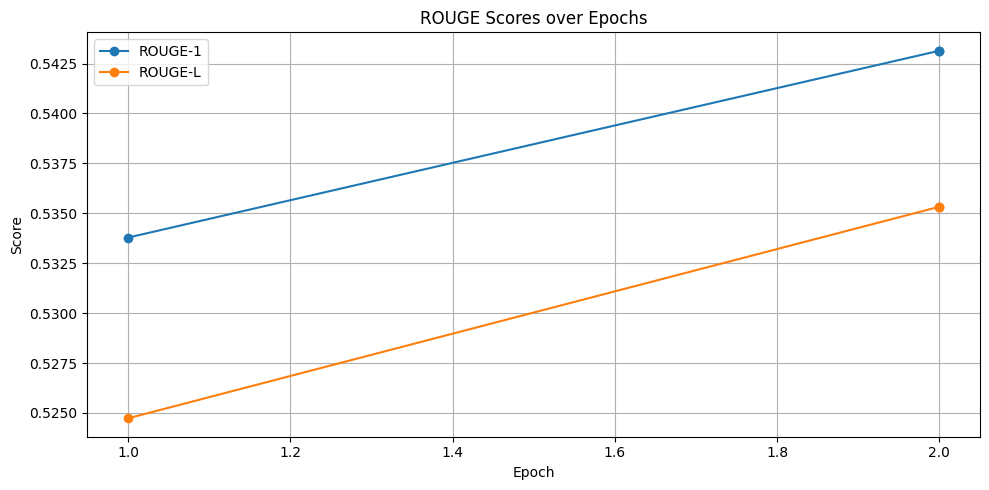

In [43]:
# Plot ROUGE-1 and ROUGE-L scores over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, rouge1_scores, marker='o', label='ROUGE-1')
plt.plot(epochs, rougeL_scores, marker='o', label='ROUGE-L')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('ROUGE Scores over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#ADD TO YOUR REPORT :
#INTERPRETATION : The line plot shows a steady increase in both ROUGE-1 and ROUGE-L scores over training epochs, indicating that the model's ability to generate relevant and coherent questions improved progressively. ROUGE-1 evaluates unigram overlap, while ROUGE-L captures longest common subsequence similarity, so their combined trend confirms enhanced syntactic and semantic alignment with reference questions.

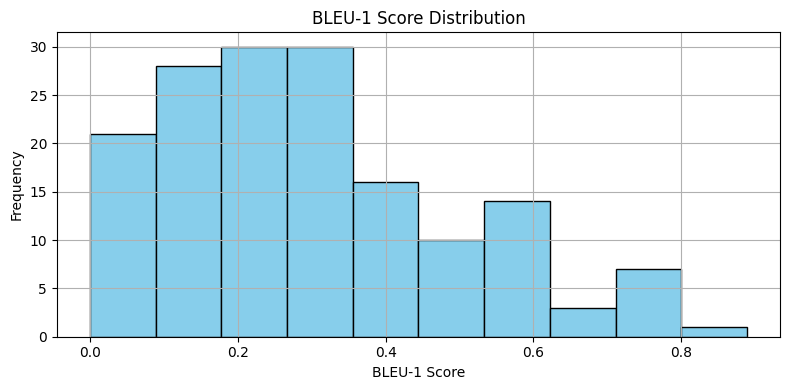

In [44]:
#Histogram: BLEU-1 Score Distribution
import matplotlib.pyplot as plt

# BLEU score histogram
plt.figure(figsize=(8, 4))
plt.hist(bleu_scores, bins=10, color='skyblue', edgecolor='black')
plt.title('BLEU-1 Score Distribution')
plt.xlabel('BLEU-1 Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

#INTERPRETATION : The BLEU-1 histogram reveals that most generated questions received lower unigram overlap scores, with only a few predictions achieving high similarity with the reference. This is expected in generative tasks, especially when multiple valid phrasings exist for a single question.

In [47]:
print("Length of BLEU-1 scores:", len(bleu_scores))
print("Length of ROUGE-1 scores:", len(rouge1_scores))


Length of BLEU-1 scores: 160
Length of ROUGE-1 scores: 3


In [48]:
import evaluate
rouge = evaluate.load("rouge")

rouge1_scores = []
rougeL_scores = []

for pred, ref in zip(decoded_preds, decoded_refs):
    result = rouge.compute(predictions=[pred], references=[ref])
    rouge1_scores.append(result["rouge1"])
    rougeL_scores.append(result["rougeL"])


In [49]:
print("Length of BLEU-1 scores:", len(bleu_scores))
print("Length of ROUGE-1 scores:", len(rouge1_scores))

Length of BLEU-1 scores: 160
Length of ROUGE-1 scores: 160


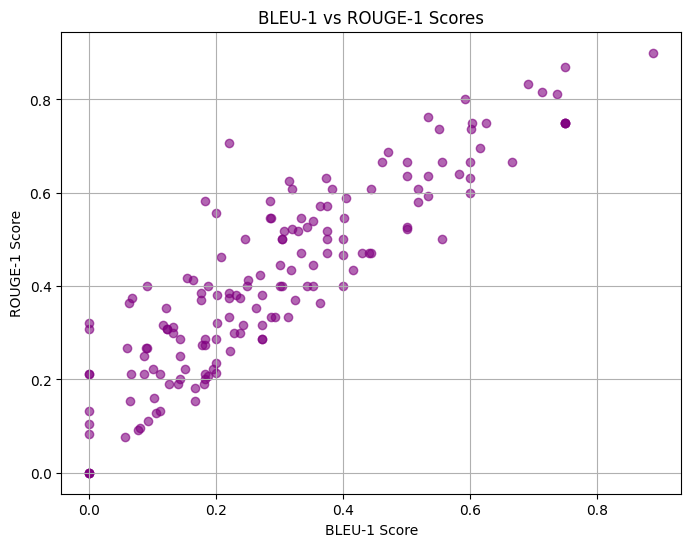

In [50]:
#Scatter Plot Between BLEU-1 and ROUGE-1
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(bleu_scores, rouge1_scores, alpha=0.6, color='purple')
plt.title('BLEU-1 vs ROUGE-1 Scores')
plt.xlabel('BLEU-1 Score')
plt.ylabel('ROUGE-1 Score')
plt.grid(True)
plt.show()

#Interpretation : To assess the quality of the generated questions, we computed BLEU-1, ROUGE-1, and ROUGE-L scores across the evaluation set. While BLEU-1 captures exact n-gram overlap, ROUGE measures both lexical and semantic similarity more flexibly. A scatter plot comparing BLEU-1 and ROUGE-1 scores showed moderate variation, with some samples scoring high on ROUGE despite lower BLEU, suggesting semantic validity despite lexical mismatch. This highlights the limitation of using a single metric and motivates multi-metric evaluation for generative tasks.